Importing libraries

In [104]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [105]:
#setup matplot's deafults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [157]:
#import data preprocessing libraries
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [303]:
#import feature engineering libraries
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.cluster import KMeans


In [108]:
#import model libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [109]:
#import metric evaliation libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve

In [110]:
import os

In [111]:
import warnings
warnings.filterwarnings('ignore')

Downloading data:
Data was downloaded using Kaggle Api
kaggle competitions download -c house-prices-advanced-regression-techniques
After that datasets where unzipped to further use

In [112]:
#loading train and test dataset
train = pd.read_csv('train.csv', index_col = 'Id')
test = pd.read_csv('test.csv', index_col = 'Id')

In [113]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

Data visualisation
The best way to get some insights of what is going on in a dataset is to make a data visualisation

In [114]:
train.shape


(1460, 80)

In [40]:
train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

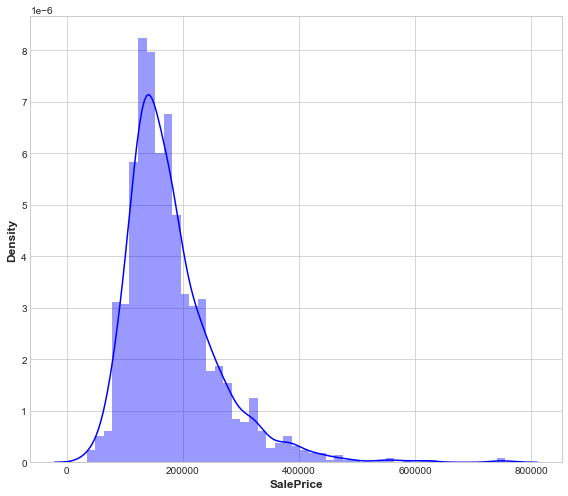

In [12]:
#Let's see how is SalePrice distributed
plt.figure(figsize = (8,7))
dist = sns.distplot(train['SalePrice'],color = 'blue',kde = True)

plt.show()

The distribution figure shows that SalePrice is not normaly distributed and will require further standardize.

Now lets see the correlation with each data and the SalePrice

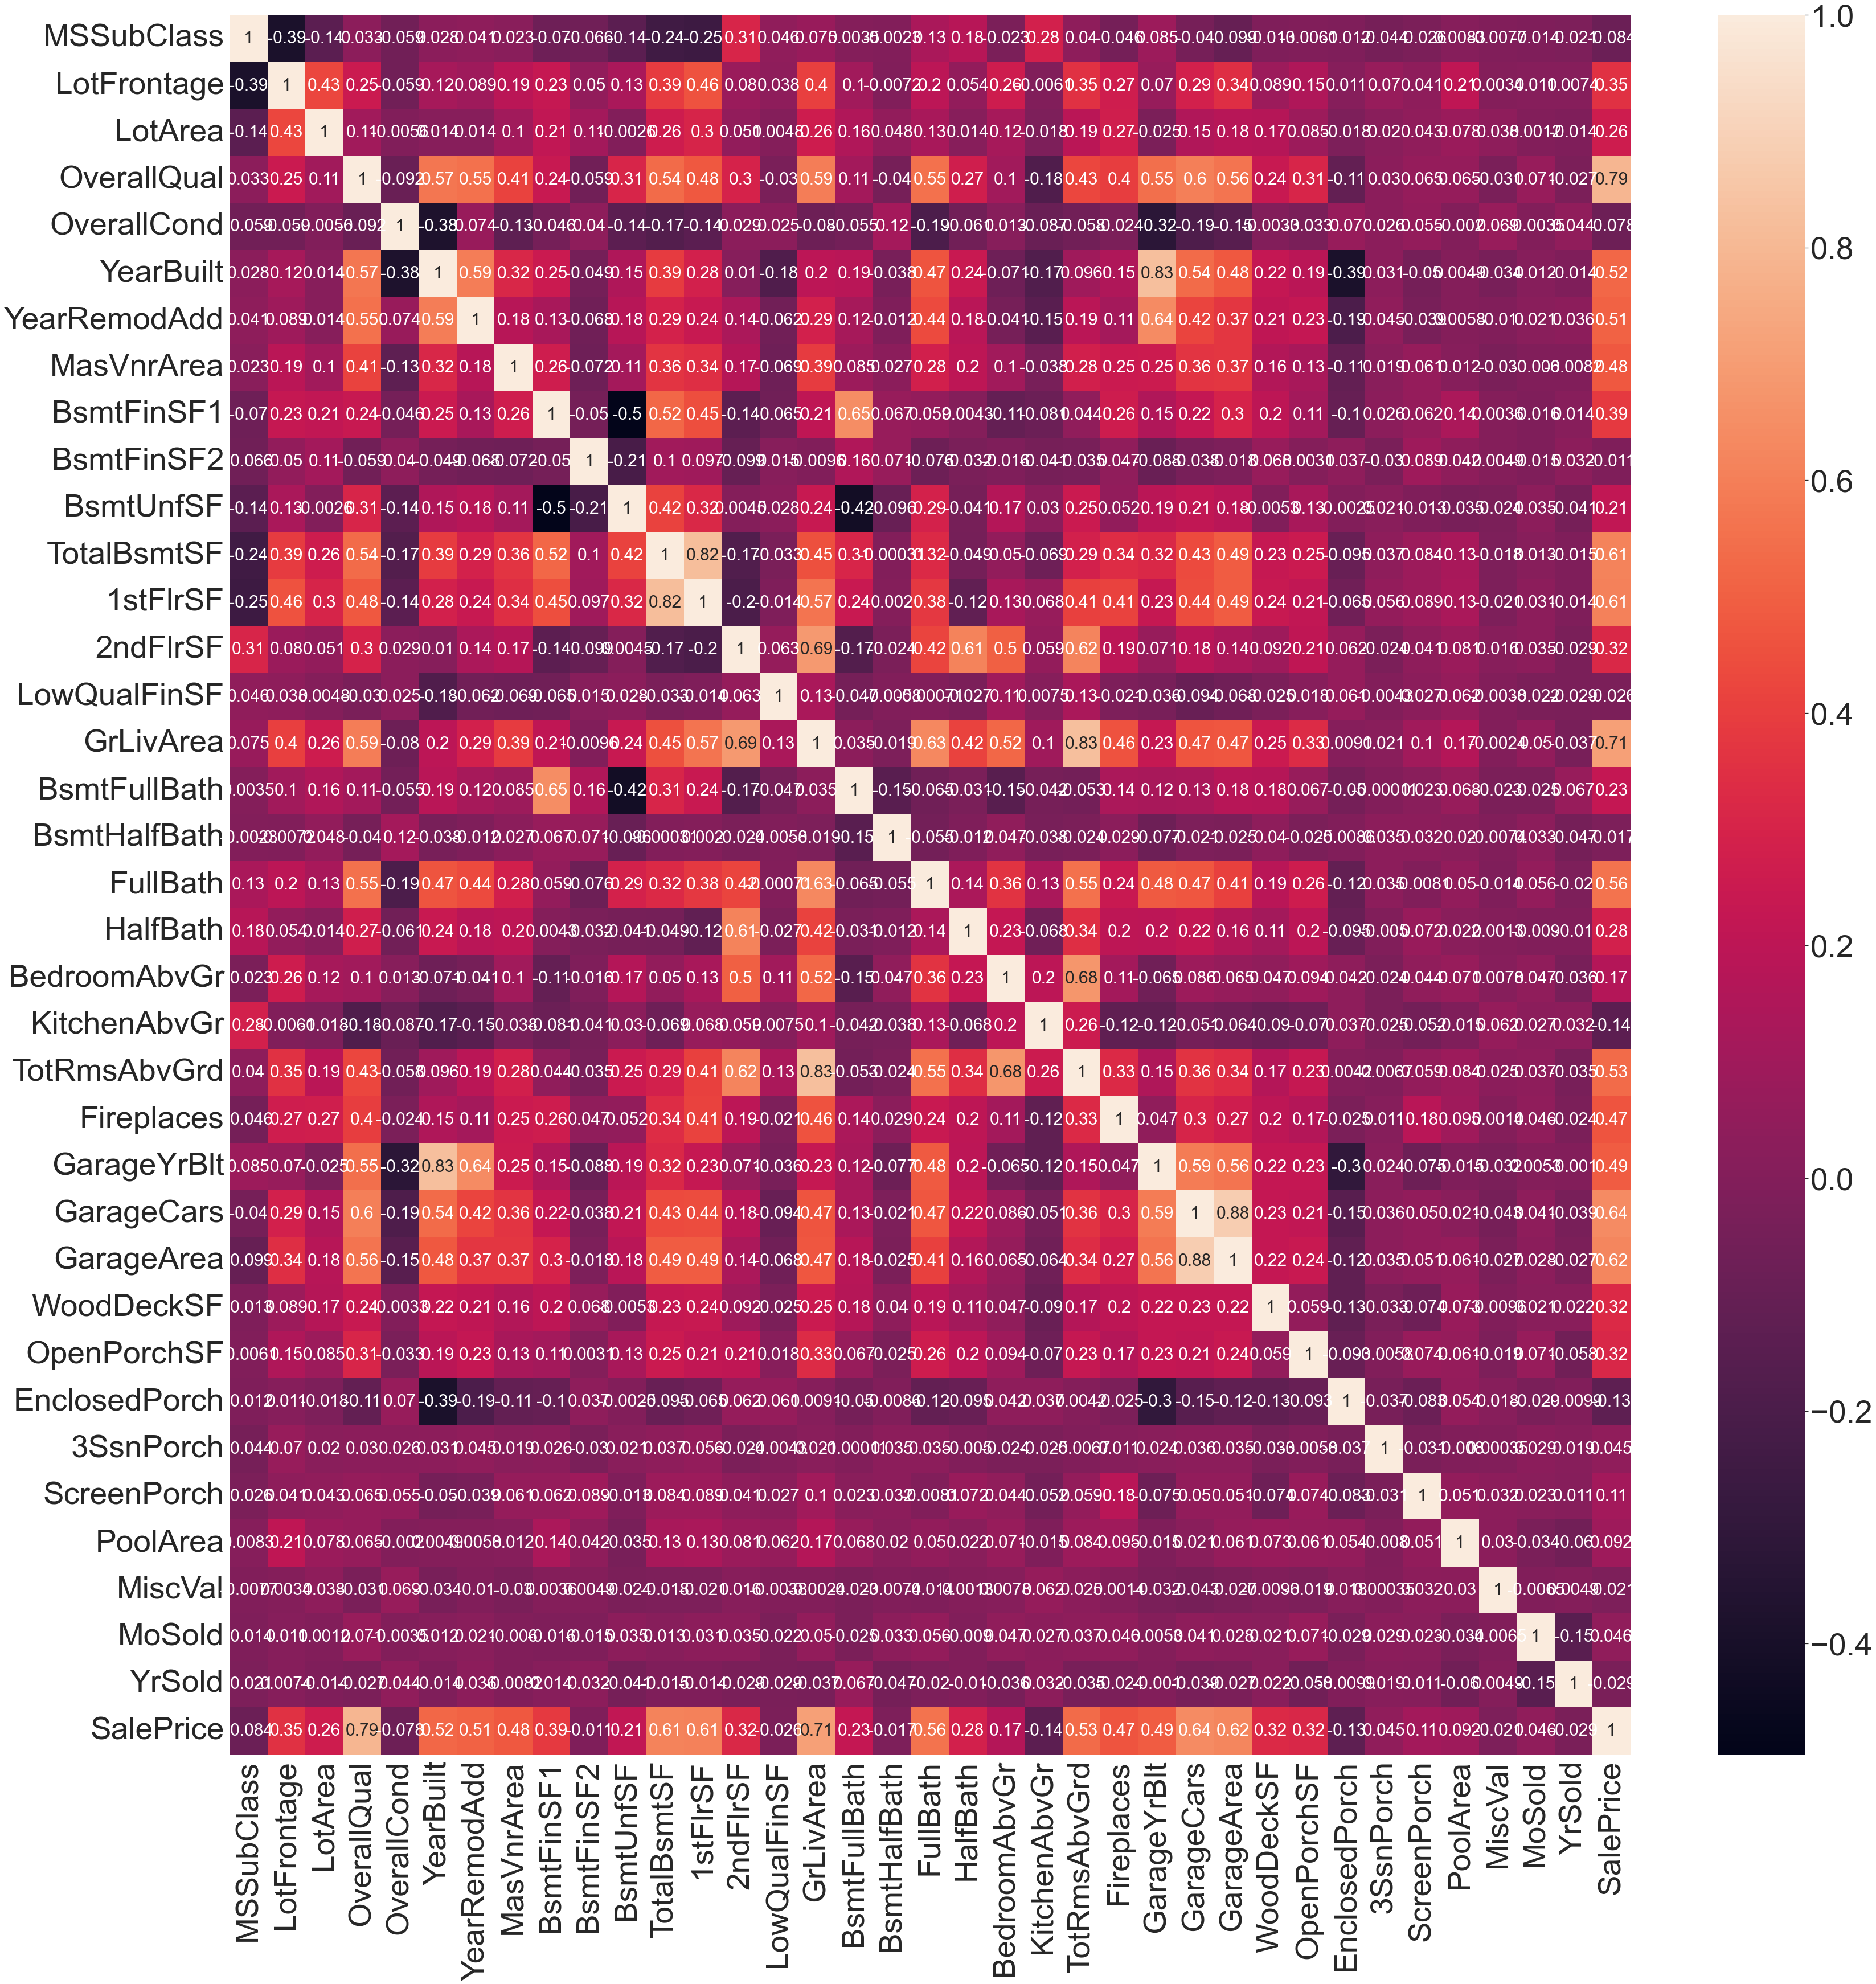

In [13]:
plt.figure(figsize = (50,50))

corr = train.corr()
sns.set(font_scale = 5)
sns.heatmap(corr,annot = True,annot_kws={"size": 30})
plt.show()


In [115]:
train.corr()['SalePrice'].sort_values(ascending=False)[1:11]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

10 Highest correlation with SalePrice:
1. OverallQual - 0.79 - Rates the overall material and finish of the house
2. GrLivArea - 0.71 - Above grade (ground) living area square feet
3. GarageCars - 0.64 - Size of garage in car capacity
4. GarageArea - 0.62 - Size of garage in square feet
5. Total BsmtSF  - 0.61 - Total square feet of basement area
6. 1stFlrSf - 0.61 - First Floor square feet
7. FullBath - 0.56 - Full bathrooms above grade
8. TotRmsAbvGrd - 0.53 - Total rooms above grade (does not include bathrooms)
9. YearBuild - 0.52 - Original construction date
10. YearRemodAdd - 0.51 - Remodel date (same as construction date if no remodeling or additions)

/In addition to above/
In the furher part of work, features like GarageCars & GarageArea that are highly correlated which each other,
will be careful examined in terms of feature engineering


Now lets plot those values in order to see if there are some obvious outliners

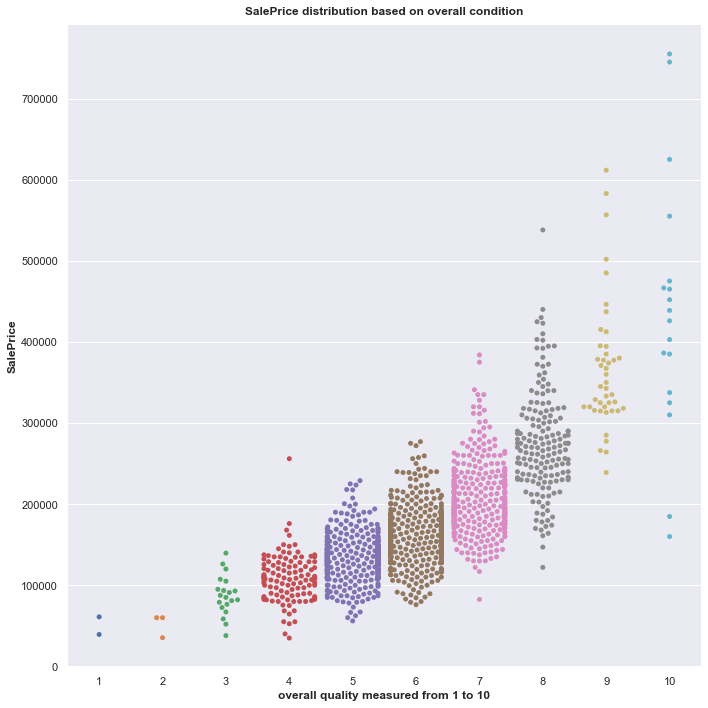

In [15]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
qual = sns.swarmplot(x = train['OverallQual'],y=train['SalePrice'])
qual.set(title = "SalePrice distribution based on overall condition",xlabel = 'overall quality measured from 1 to 10')
sns.despine()
plt.show()

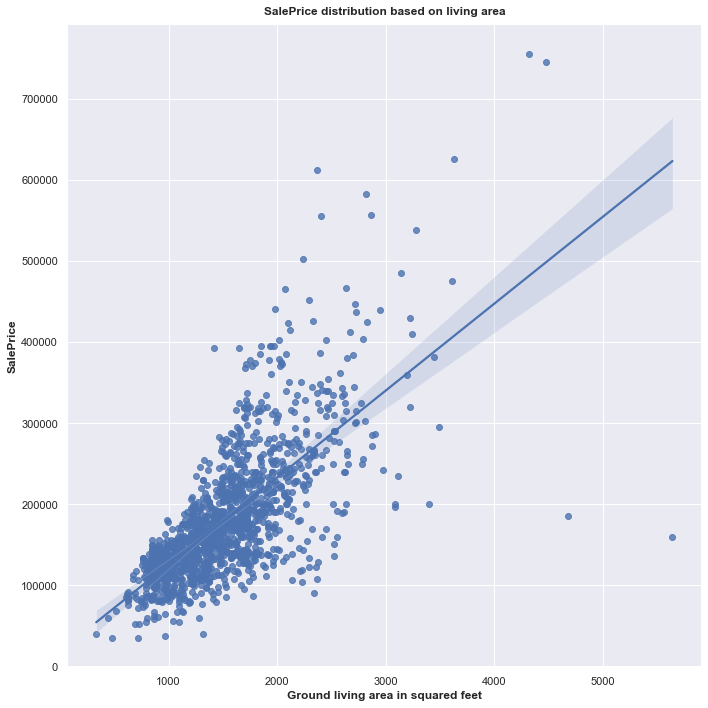

In [16]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
liv_area = sns.regplot(x = train['GrLivArea'], y = train['SalePrice'])
liv_area.set(title = 'SalePrice distribution based on living area',xlabel = 'Ground living area in squared feet')
sns.despine()
plt.show()

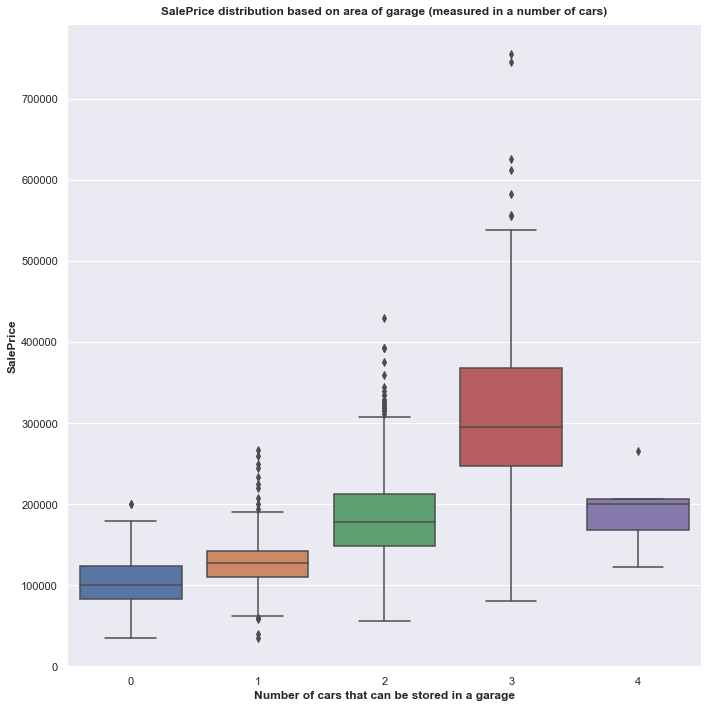

In [17]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
garage_cars = sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])
garage_cars.set(title = 'SalePrice distribution based on area of garage (measured in a number of cars)',xlabel = 'Number of cars that can be stored in a garage')
sns.despine()
plt.show()

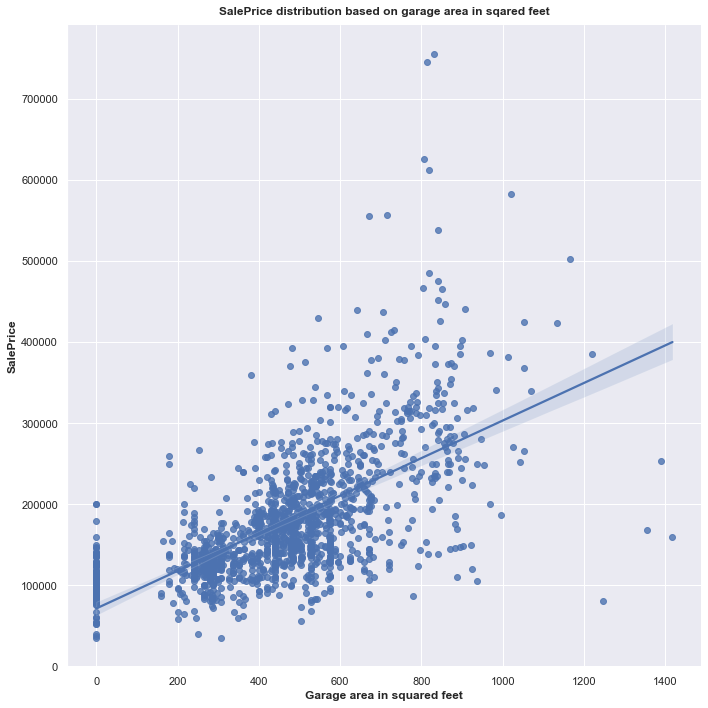

In [18]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
gar_area = sns.regplot(x = train['GarageArea'], y = train['SalePrice'])
gar_area.set(title = 'SalePrice distribution based on garage area in sqared feet',xlabel = 'Garage area in squared feet' )
sns.despine()
plt.show()

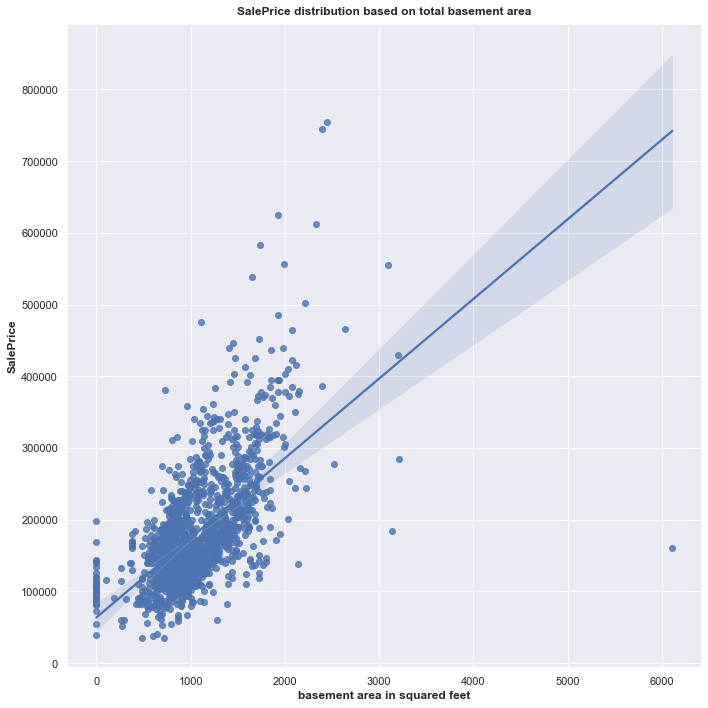

In [19]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
bsmt_area = sns.regplot(x = train['TotalBsmtSF'], y = train['SalePrice'])
bsmt_area.set(title = 'SalePrice distribution based on total basement area',xlabel = 'basement area in squared feet')
sns.despine()
plt.show()

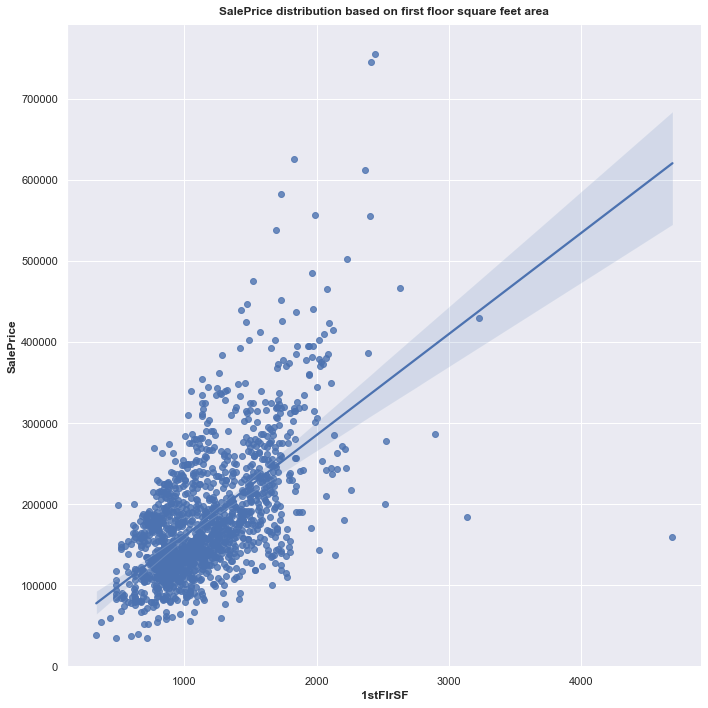

In [20]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
fst_area = sns.regplot(x = train['1stFlrSF'], y = train['SalePrice'])
fst_area.set(title = 'SalePrice distribution based on first floor square feet area')
sns.despine()
plt.show()

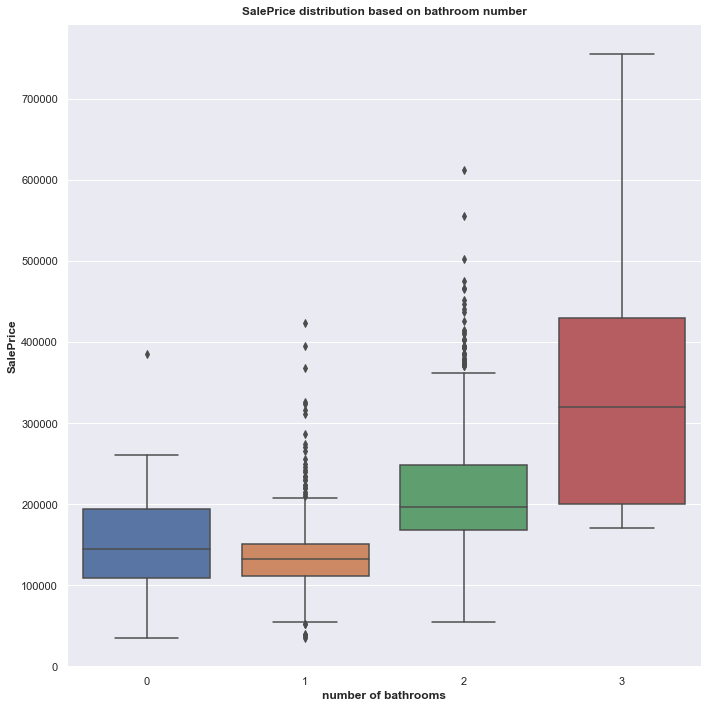

In [21]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
num_bath = sns.boxplot(x = train['FullBath'], y = train['SalePrice'])
num_bath.set(title = 'SalePrice distribution based on bathroom number',xlabel = 'number of bathrooms')
sns.despine()
plt.show()

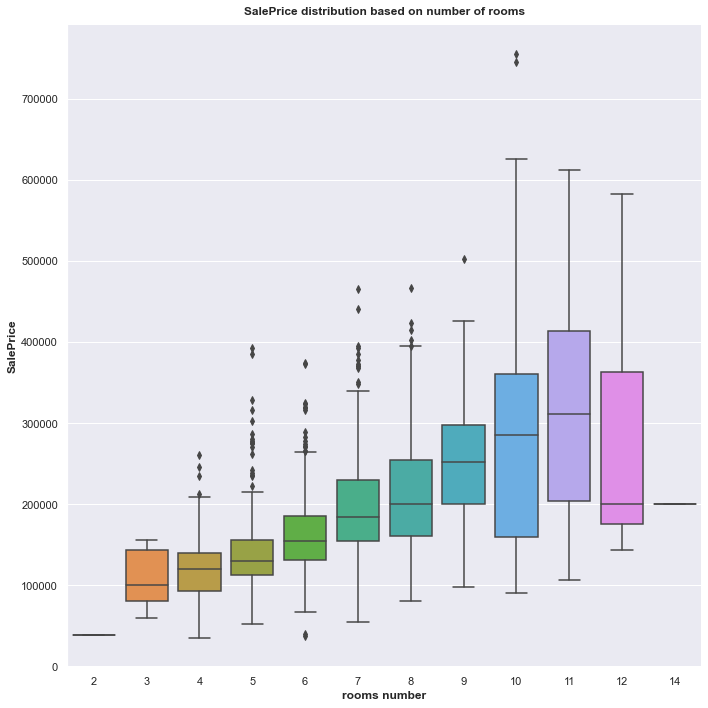

In [22]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
num_room = sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])
num_room.set(title = 'SalePrice distribution based on number of rooms',xlabel = 'rooms number')
sns.despine()
plt.show()

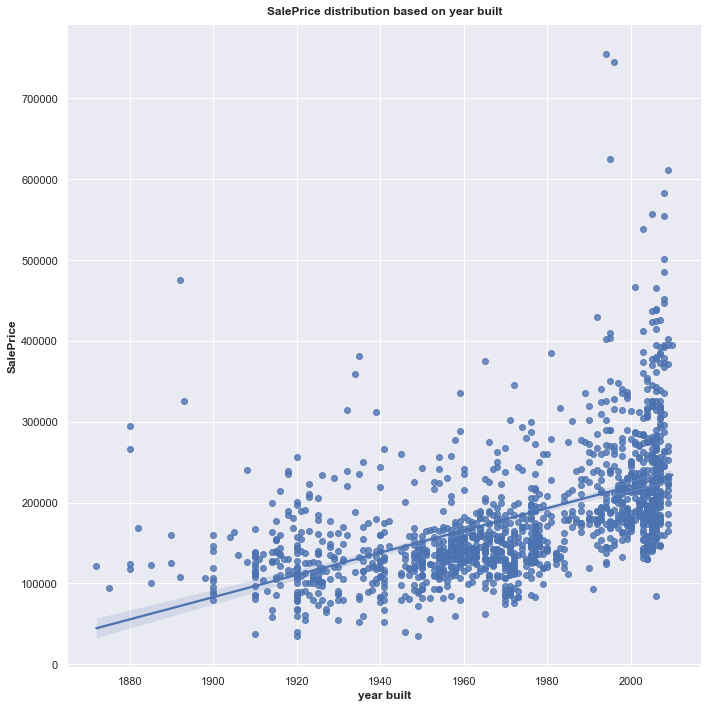

In [23]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
yr_built= sns.regplot(x = train['YearBuilt'], y = train['SalePrice'])
yr_built.set(title = 'SalePrice distribution based on year built',xlabel = 'year built')
sns.despine()
plt.show()

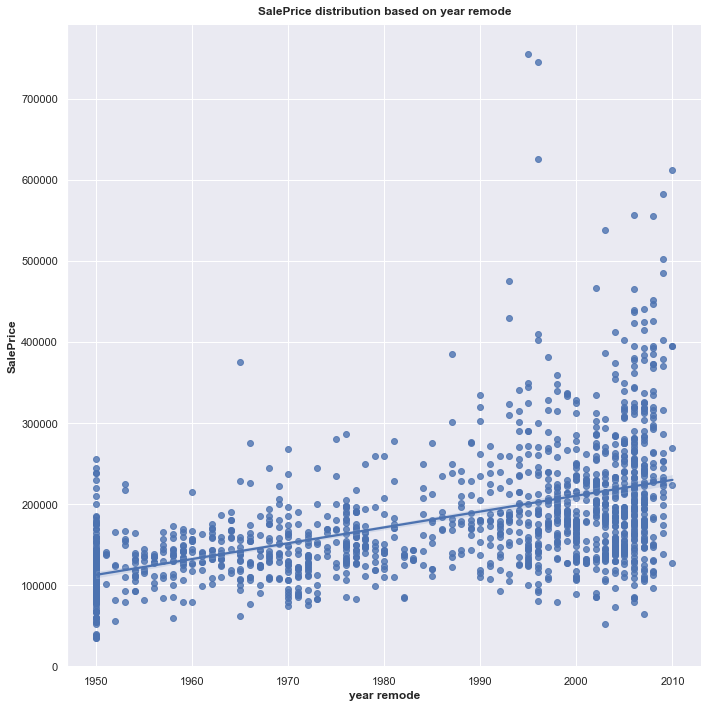

In [24]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
yr_remode= sns.regplot(x = train['YearRemodAdd'], y = train['SalePrice'])
yr_remode.set(title = 'SalePrice distribution based on year remode',xlabel = 'year remode')
sns.despine()
plt.show()

Lets investigate missing values

In [116]:
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending = False) #printing columns with missing values


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

First, lets consider those missing values which accualy are informative. According to data_description:
1. Nan in PoolQC means no pool
2. Nan in MiscFeatures means no miscellaneous feature
3. Nan in Alley means no alley acces
4. Nan in Fence means no fence
5. Nan in FireplaceQu means no fireplace

In [117]:
no_missing = train.copy()
no_missing.isnull().sum()[no_missing.isnull().sum()>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [118]:
no_missing['PoolQC'] = no_missing['PoolQC'].fillna('None')
no_missing['MiscFeature'] = no_missing['MiscFeature'].fillna('None')
no_missing['Alley'] = no_missing['Alley'].fillna('None')
no_missing['Fence'] = no_missing['Fence'].fillna('None')
no_missing['FireplaceQu'] = no_missing['FireplaceQu'].fillna('None')

As we can see there are 81 missing values per garage's features which is connected with a non existance of a garage, 38 with a basement and 8 with a masonry veneer type

In [119]:
gar_cat_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
no_missing['GarageYrBlt'] =no_missing['GarageYrBlt'].astype(float) 
no_missing['GarageYrBlt'] = no_missing['GarageYrBlt'].fillna(0)
for fit in gar_cat_features:
    no_missing[fit] = no_missing[fit].fillna('None')

As far as Lot Frontage is considered, lets examine it's correlation to find out what would be the most suitale way of filling missing values

In [120]:
no_missing.corr()['LotFrontage'].sort_values(ascending = False)[1:5]
#It shows features that might be helpful in filling missing valuses, but lets also consider categorical feature: neighbrhood

1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
Name: LotFrontage, dtype: float64

In [121]:
no_missing[['LotArea','LotFrontage','1stFlrSF','GrLivArea','Neighborhood']].sort_values(by = '1stFlrSF').head(20)
#while sorting by each of this features it appeared that the appropriate way is to fill missing values based on neighbor hood

LotArea  LotFrontage  1stFlrSF  GrLivArea Neighborhood
Id                                                          
534      5000         50.0       334        334      BrkSide
706      5600         70.0       372       1092       IDOTRR
1101     8400         60.0       438        438        SWISU
917      9000         50.0       480        480       IDOTRR
431      1680         21.0       483        987       BrDale
838      1680         21.0       483        987       BrDale
236      1680         21.0       483        987       BrDale
1379     1953         21.0       483        987       BrDale
233      1680         21.0       483        987       BrDale
228      1869         21.0       483        987       BrDale
364      1680         21.0       483        987       BrDale
363      7301         64.0       495       1922      Edwards
126      6780         60.0       520        754       IDOTRR
30       6324         60.0       520        520      BrkSide
832      3180         30.0       520       1200      Somerst
1365     3180         30.0       520       1200      Somerst
830      2544         24.0       520       1223      Somerst
656      1680         21.0       525       1092       BrDale
76       1596         21.0       526        988      MeadowV
345      2592         36.0       536       1112      MeadowV

In [122]:
#Filling LotFrontage values with a mean of LotFrontage in a particular neighborhoods
no_missing['LotFrontage'] = no_missing.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [123]:
#Lack of values in basement features means there is no basement so it will be filled with None
bsmt_features = ['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']
for feature in bsmt_features:
    no_missing[feature] = no_missing[feature].fillna("None")

In [124]:
#Lack of values in Masonry veneer features will be filled with "0" for area and "None" for type
no_missing['MasVnrType'] = no_missing['MasVnrType'].fillna('None')
no_missing['MasVnrArea'] = no_missing['MasVnrArea'].fillna(0)

In [125]:
#With the electrical column it will be used to filled with  a most common value
no_missing.groupby('Electrical').count()
no_missing['Electrical'] = no_missing['Electrical'].fillna('SBrkr')

In [126]:
no_missing.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

Having filled missing values the next step is feature engineering

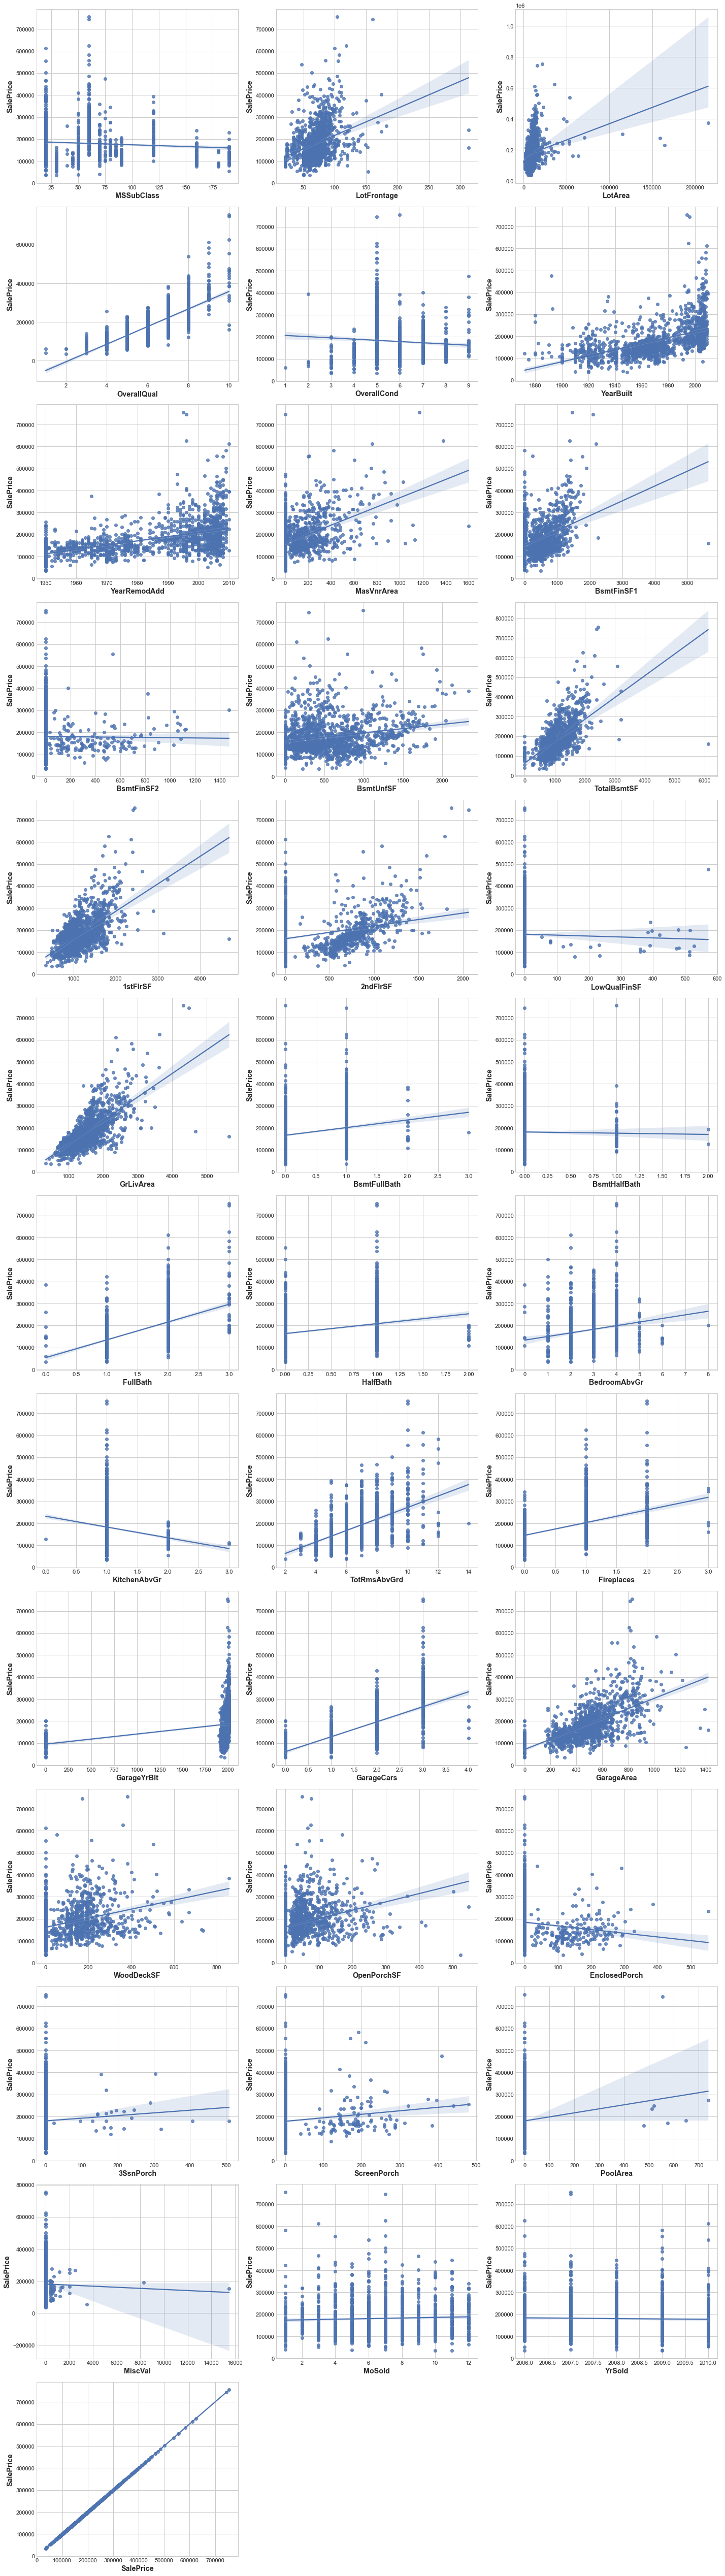

In [127]:
#Firstly lets remove outliars, to achieve this lets make a look on num variables again.
num_col = [col for col in no_missing.columns if no_missing[col].dtype != 'object'] #here are numerical columns
#now lets make a big suplot of those columns
fig, axs = plt.subplots(figsize=(20, 200)) #make a big figure for  subplots
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(num_col, 1):
    plt.subplot(len(num_col), 3, i)
    regs = sns.regplot(x=no_missing[feature], y=no_missing['SalePrice'])      
        
plt.show()

As we can see there are some outliers:
1. LotFrontage > 300 & SalePrice < 300000
2. BsmnFinSF1 > 5000 & SalePrice < 200000
3. TotalBsmtSF > 6000 & SalePrice < 200000
4. GrLivArea > 4000 & SalePrice <20000

In [129]:
no_missing = no_missing.drop(no_missing[(no_missing['GrLivArea']>4000) & (train['SalePrice']<200000)].index)
no_missing = no_missing.drop(no_missing[(no_missing['LotFrontage']>300) & (no_missing['SalePrice']<300000)].index)

The second important thing that comes with regplots is the fact that MoSold and YrSold doesnt have an impact on SalePrice so those features should be deleted

In [188]:
no_missing = no_missing.drop(['MoSold','YrSold'],axis = 1)


KeyError: "['MoSold' 'YrSold'] not found in axis"

In [183]:
X = no_missing.copy()
y = X.SalePrice
X = X.drop(['SalePrice'],axis = 1)

In [204]:
discrete_features = X[num_col].dtypes == int

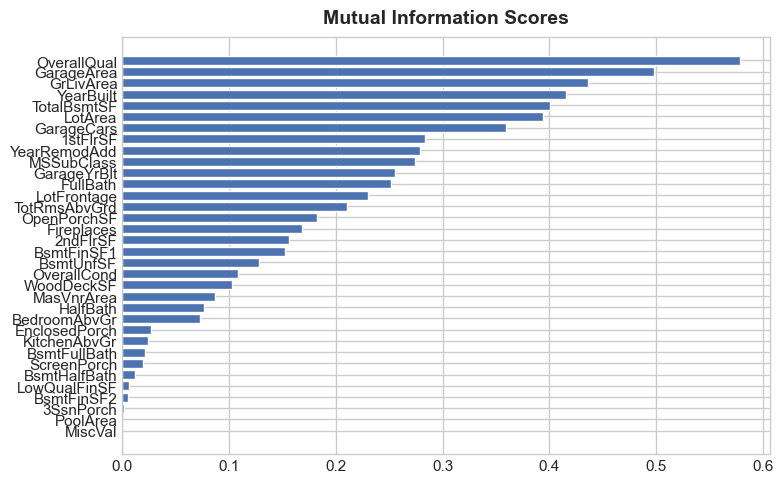

In [217]:
def mi_scores(x,y,discrete_features):
  mi_score = mutual_info_regression(x,y,discrete_features = discrete_features)
  mi_score = pd.Series(mi_score,name = 'MI scores',index = x.columns)
  mi_score = mi_score.sort_values(ascending = False)
  return mi_score

mi_scores(X[num_col],y,discrete_features)
#teraz czas na splotowanie wykresu dla lepszej analizy
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores(X[num_col],y,discrete_features))

In [221]:
xd = no_missing.copy()
xd.head()
for colname in xd.select_dtypes("object"):
    xd[colname], _ = xd[colname].factorize()
xd[OrdinalEnc].head()

ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
Id                                                                         
1           0          0         0         0             0             0   
2           1          0         0         0             1             1   
3           0          0         0         0             2             0   
4           1          0         1         1             0             1   
5           0          0         0         0             3             0   

    BsmtFinType2  HeatingQC  KitchenQual  FireplaceQu  GarageQual  GarageCond  \
Id                                                                              
1              0          0            0            0           0           0   
2              0          0            1            1           0           0   
3              0          0            0            1           0           0   
4              0          1            0            2           0           0   
5              0          0            0            1           0           0   

    PoolQC  Fence  
Id                 
1        0      0  
2        0      0  
3        0      0  
4        0      0  
5        0      0

Looking for outliar using PCA method

Standardize distribution of numerical variables

In [222]:
no_missing[OrdinalEnc].head()

ExterQual ExterCond BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
Id                                                                   
1         Gd        TA       Gd       TA           No          GLQ   
2         TA        TA       Gd       TA           Gd          ALQ   
3         Gd        TA       Gd       TA           Mn          GLQ   
4         TA        TA       TA       Gd           No          ALQ   
5         Gd        TA       Gd       TA           Av          GLQ   

   BsmtFinType2 HeatingQC KitchenQual FireplaceQu GarageQual GarageCond  \
Id                                                                        
1           Unf        Ex          Gd        None         TA         TA   
2           Unf        Ex          TA          TA         TA         TA   
3           Unf        Ex          Gd          TA         TA         TA   
4           Unf        Gd          Gd          Gd         TA         TA   
5           Unf        Ex          Gd          TA         TA         TA   

   PoolQC Fence  
Id               
1    None  None  
2    None  None  
3    None  None  
4    None  None  
5    None  None

Categorical data encoding

In [144]:
#making a list of a categorical data columns
cat_col = [col for col in no_missing.columns if no_missing[col].dtype == 'object']
rep_col = []
for i, col in enumerate(no_missing.columns, 1): #check wheter there are no repetitions
    if col in cat_col and col in num_col:
        rep_col.append(col)
    else:
        rep_col.append(i)
print(rep_col)   


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78]

In [302]:
#lets devide categorical that suit for LabelEncodin (connected with quality) and OGetting dummies
OneHotEnc = []
LabelEnc = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','Fence',]
for col in cat_col:
    if col not in LebelEnc:
        OneHotEnc.append(col)
#Now we can encode columns with a chosen methods
#LabelEncoding --> for those features that comes with an intuition of ordering by numbers eq. quality: good-ok-bad
label_encoding = no_missing[LabelEnc].copy()
for colname in label_encoding[LabelEnc]:
    label_encoding[colname], _ = label_encoding[colname].factorize()
#Getting dummies
dummy = no_missing[OneHotEnc].copy()
dummy = pd.get_dummies(dummy[OneHotEnc])
#joining dummies + label encoding + numerical features
numerical = no_missing.copy()
num = numerical[num_col]
train_encoded = pd.concat([num,label_encoding,dummy],axis = 1)
train_encoded.dropna(axis = 0, inplace = True)
train_encoded



MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
Id                                                      ...                   
1             2003       196.0         706           0  ...               0   
2             1976         0.0         978           0  ...               0   
3             2002       162.0         486           0  ...               0   
4             1970         0.0         216           0  ...               0   
5             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          2000         0.0           0           0  ...               0   
1457          1988       119.0         790         163  ...               0   
1458          2006         0.0         275           0  ...               0   
1459          1996         0.0          49        1029  ...               0   
1460          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      1   
5                0             0            1                      0   
...            ...           ...          ...                    ...   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   
1460             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
5                         0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   
1460                      0                     0                     0   

      SaleCondition_Normal  SaleCondi

In [308]:
km = train_encoded.copy()
kmeans = KMeans(n_clusters = 6)
km["Cluster"] = kmeans.fit_predict(km)
km["Cluster"] = km["Cluster"].astype("category")
#wyniki przedstawiamy na wykresach na rozne sposoby np
# wykres przedstawiajacy rozpeitosc klastrow pod wzgledem polozenia geograficznego
#sns.relplot(
    #x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
#);
#wykres przedstawiajacy rozpietosc targetu dla poszczegolnych kladtrow
#X["MedHouseVal"] = df["MedHouseVal"]
#sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);
